In [1]:
# Importing necessary libraries to unzip `tiny-imagenet-200.zip`
import os
import zipfile
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
#import custom modules
from models.cnn import SimpleCNN
from models.resnet18 import ResNet18
from models.ccn512 import SimpleCNN512

In [3]:
# Unzip the dataset
#with zipfile.ZipFile("tiny-imagenet-200.zip", 'r') as zip_ref:
#    zip_ref.extractall()

In [4]:
# Lets see the directory structure of tiny-imagenet-200
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        jpeg_files = [f for f in files if f.endswith('.JPEG')]
        if jpeg_files:  # if the list is not empty
            print('{}Number of JPEG files: {}'.format(subindent, len(jpeg_files)))
        for f in files:
            if f.endswith('.txt'):
                print('{}{}'.format(subindent, f))

list_files('tiny-imagenet-200')

tiny-imagenet-200/
    wnids.txt
    words.txt
    test/
        images/
            Number of JPEG files: 10000
    train/
        n01443537/
            n01443537_boxes.txt
            images/
                Number of JPEG files: 500
        n01629819/
            n01629819_boxes.txt
            images/
                Number of JPEG files: 500
        n01641577/
            n01641577_boxes.txt
            images/
                Number of JPEG files: 500
        n01644900/
            n01644900_boxes.txt
            images/
                Number of JPEG files: 500
        n01698640/
            n01698640_boxes.txt
            images/
                Number of JPEG files: 500
        n01742172/
            n01742172_boxes.txt
            images/
                Number of JPEG files: 500
        n01768244/
            n01768244_boxes.txt
            images/
                Number of JPEG files: 500
        n01770393/
            n01770393_boxes.txt
            images/
              

In [5]:
# Path and Files
path = './tiny-imagenet-200/train/'
wnid_labels = dict(line.strip().split('\t') for line in open('./tiny-imagenet-200/words.txt'))  # Corrected path
dirs = os.listdir(path)

# Read the wnids from wnids.txt into a set
with open('./tiny-imagenet-200/wnids.txt') as f:
    wnids = {line.strip() for line in f}

# Filter wnid_labels to only include the wnids in Tiny ImageNet
wnid_labels = {wnid: desc for wnid, desc in wnid_labels.items() if wnid in wnids}

len(wnid_labels) # We only want the mappings that are in tinynet

200

In [6]:
# Define the function to randomly sample n images
def rsample_images(n):
    """
    Sample n random images from the train directory along with their English wnid representations and bounding boxes.

    Args:
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    for _ in range(n):
        random_dir = random.choice(dirs)
        random_image = random.choice(os.listdir(os.path.join(path, random_dir, 'images')))
        box_data = [line.strip().split('\t') for line in open(os.path.join(path, random_dir, f"{random_dir}_boxes.txt"))]
        box_for_image = [box for box in box_data if box[0] == random_image][0]
        samples_with_boxes.append((random_dir, os.path.join(path, random_dir, 'images', random_image), box_for_image))

    return samples_with_boxes

In [7]:
# Define the function to sample n images by wordnet-id
def sample_images_by_wnid(wnid, n):
    """
    Sample 'n' images of a specific wnid from the train directory along with their English wnid representations and bounding boxes.

    Args:
    wnid (str): The wnid of the images to sample.
    n (int): The number of images to sample.

    Returns:
    List[Tuple]: A list of tuples where each tuple contains wnid, image path, and bounding box.
    """
    samples_with_boxes = []
    image_dir = os.path.join(path, wnid, 'images')
    box_data = [line.strip().split('\t') for line in open(os.path.join(path, wnid, f"{wnid}_boxes.txt"))]
    
    for image_name in os.listdir(image_dir)[:n]:
        box_for_image = [box for box in box_data if box[0] == image_name][0]
        samples_with_boxes.append((wnid, os.path.join(image_dir, image_name), box_for_image))

    return samples_with_boxes


In [8]:
# Define the function to display images
def display_images(samples_with_boxes):
    """
    Display images along with their English wnid representations and bounding boxes.

    Args:
    samples_with_boxes (List[Tuple]): A list of tuples where each tuple contains wnid, image path, and bounding box.

    Returns:
    None
    """
    n = len(samples_with_boxes)
    fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
    if n == 1:
        axs = [axs]
    for i, (wnid, img_path, box) in enumerate(samples_with_boxes):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].title.set_text(wnid_labels[wnid])
        axs[i].title.set_fontsize(8)

        x, y, w, h = map(int, box[1:])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

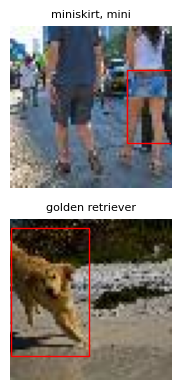

In [9]:
display_images(rsample_images(2))

In [10]:
#display_images(sample_images_by_wnid('n02099601',2))

In [11]:
# Here's how you can create a DataLoader for your dataset. Remember, this code won't run in this environment but you can use it as a template in your local environment:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load Tiny ImageNet dataset
train_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/train', transform=transform)
val_dataset = datasets.ImageFolder(root='./tiny-imagenet-200/val', transform=transform)



# Create data loaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
len(train_loader)

1000

In [13]:
# Inspect a batch from train_loader
train_images, train_labels = next(iter(train_loader))
print("Train images batch shape:", train_images.shape)
print("Train labels batch shape:", train_labels.shape)
print("Train images data type:", train_images.dtype)
print("Train labels data type:", train_labels.dtype)

# Inspect a batch from val_loader
val_images, val_labels = next(iter(val_loader))
print("Validation images batch shape:", val_images.shape)
print("Validation labels batch shape:", val_labels.shape)
print("Validation images data type:", val_images.dtype)
print("Validation labels data type:", val_labels.dtype)


Train images batch shape: torch.Size([100, 3, 64, 64])
Train labels batch shape: torch.Size([100])
Train images data type: torch.float32
Train labels data type: torch.int64
Validation images batch shape: torch.Size([100, 3, 64, 64])
Validation labels batch shape: torch.Size([100])
Validation images data type: torch.float32
Validation labels data type: torch.int64


In [14]:
def train_model(model, train_loader, batch_size, criterion, optimizer, device, num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        loss_list = []
        acc_list = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop and perform optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            # Uncomment for batch-wise training summaries
            #if (i + 1) % batch_size == 0:
            #    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {100*(correct / total):.2f}%')

        epoch_loss = np.mean(loss_list)
        epoch_acc = np.mean(acc_list)
        print(f'End of Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {100*epoch_acc:.2f}%')

    # Print the last epoch's average loss and accuracy
    print(f"\nFinal Training accuracy: {100*epoch_acc:.2f}%, Final Training loss: {epoch_loss:.4f}")


In [15]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():  # We don't need gradients for evaluation
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    print(f'Final Validation accuracy: {100 * correct / total:.2f}%, Final Validation loss: {total_loss / len(val_loader):.4f}')

### Train CNN's

In [16]:
# Initialize SimpleCNN model and hyperparameters
cnn_model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

# Train and then evaulate our model
train_model(cnn_model, train_loader, batch_size, criterion, optimizer, device, num_epochs) # optimizer changed to adam
evaluate_model(cnn_model, val_loader, criterion, device)

# Assume model is your trained model
torch.save(cnn_model.state_dict(), "./model_params/cnn_model_parameters.pth")

End of Epoch [1/10], Loss: 4.7862, Accuracy: 4.47%
End of Epoch [2/10], Loss: 4.1842, Accuracy: 11.27%
End of Epoch [3/10], Loss: 3.9043, Accuracy: 15.31%
End of Epoch [4/10], Loss: 3.7574, Accuracy: 17.62%
End of Epoch [5/10], Loss: 3.6517, Accuracy: 19.14%
End of Epoch [6/10], Loss: 3.5649, Accuracy: 20.47%
End of Epoch [7/10], Loss: 3.4982, Accuracy: 21.66%
End of Epoch [8/10], Loss: 3.4435, Accuracy: 22.41%
End of Epoch [9/10], Loss: 3.3930, Accuracy: 23.36%
End of Epoch [10/10], Loss: 3.3484, Accuracy: 24.03%

Final Training accuracy: 24.03%, Final Training loss: 3.3484
Final Validation accuracy: 18.39%, Final Validation loss: 3.7929


In [17]:
# Initialize SimpleCNN512 model and hyperparameters
cnn_model_512 = SimpleCNN512()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_512.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

# Train and then evaulate our model
train_model(cnn_model_512, train_loader, batch_size, criterion, optimizer, device, num_epochs) # optimizer changed to adam
evaluate_model(cnn_model_512, val_loader, criterion, device)

# Assume model is your trained model
torch.save(cnn_model_512.state_dict(), "./model_params/cnn_model_512_parameters.pth")

End of Epoch [1/10], Loss: 4.6436, Accuracy: 5.96%
End of Epoch [2/10], Loss: 3.9814, Accuracy: 14.07%
End of Epoch [3/10], Loss: 3.6508, Accuracy: 18.94%
End of Epoch [4/10], Loss: 3.3962, Accuracy: 23.07%
End of Epoch [5/10], Loss: 3.1712, Accuracy: 26.76%
End of Epoch [6/10], Loss: 2.9533, Accuracy: 30.29%
End of Epoch [7/10], Loss: 2.7255, Accuracy: 34.48%
End of Epoch [8/10], Loss: 2.5146, Accuracy: 38.34%
End of Epoch [9/10], Loss: 2.2933, Accuracy: 42.66%
End of Epoch [10/10], Loss: 2.0831, Accuracy: 47.07%

Final Training accuracy: 47.07%, Final Training loss: 2.0831
Final Validation accuracy: 17.02%, Final Validation loss: 4.5601


##### CNN Observations:
SimpleCNN's two dense layers are of size 120 and 84 respectively, whereas SimpleCNN512's dense layers are both of size 512.

It seems the model with 512 sized layers is overfitting right now. We have no dropout layers incorporated yet!

### Train ResNet18

In [18]:
# Initialize ResNet18 model and hyperparameters with SGD optimizer
model = ResNet18()
#model.load_state_dict(torch.load("./model_params/model_parameters.pth")) # comment out to train fresh model
criterion = nn.CrossEntropyLoss()  # Common choice for of loss for classification problems
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Common choice of optimizer for CNNs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10

# Train and then evaulate our model
train_model(model, train_loader, batch_size, criterion, optimizer, device, num_epochs)
evaluate_model(model, val_loader, criterion, device)

# Assume model is your trained model
torch.save(model.state_dict(), "./model_params/model_parameters.pth")


End of Epoch [1/10], Loss: 4.2059, Accuracy: 11.80%
End of Epoch [2/10], Loss: 3.2209, Accuracy: 26.22%
End of Epoch [3/10], Loss: 2.7420, Accuracy: 35.08%
End of Epoch [4/10], Loss: 2.3853, Accuracy: 42.37%
End of Epoch [5/10], Loss: 2.0958, Accuracy: 48.38%
End of Epoch [6/10], Loss: 1.8313, Accuracy: 53.99%
End of Epoch [7/10], Loss: 1.5747, Accuracy: 59.59%
End of Epoch [8/10], Loss: 1.3106, Accuracy: 65.71%
End of Epoch [9/10], Loss: 1.0292, Accuracy: 72.60%
End of Epoch [10/10], Loss: 0.7367, Accuracy: 80.30%

Final Training accuracy: 80.30%, Final Training loss: 0.7367
Final Validation accuracy: 42.62%, Final Validation loss: 2.8045


### To-Do List:
- Add dropout layers to our models to work on overfitting issue!